# 3rd Segmentation of e-shop customers 

An essential application of clustering is **customer segmentation**. 

Given transactional data of the form:

>TransactionID, CustomerID, Date (of the purchase), Subtotal (the price of the purchase)

we want to find segments of customers with similar behaviour. For this, we need to aggregate the transactions and have **one row as one customer**.

A popular framework to do that is **RFM**, which means:

- **R**ecency: Day since last purchase (last date in the data set - last purchase date set of a given customer)
- **F**requency: Number of purchases. Customers with only one purchase are sometimes excluded; let's leave them in the dataset for simplicity.
- **M**onetary: Total amount spent by the customer.

## Data source

Data about purchases of an (almost) fake e-shop are in the file `eshop.csv`.

## Instructions

Take the date of the last transaction (19. 12. 2015) as the actual date of the analysis - to simulate that the data is current.


  * Create an `rfm` data frame that has as many rows as customers, where each row is a customer, and the other columns are calculated as described above.
  * Use `k-means` for clustering. Find the optimal number of clusters (explain why you have chosen it).
  * Work with scaling and standardization of the data. Is it needed? Do it if yes.
  * Give an interpretation for the clusters. Can the clusters help you identify some superstar customers (high monetary, high frequency, low recency) from lousy ones (high recency, low frequency, low monetary)? Identify them.

  *  Use the method Silhouette to analyze the found clusters (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
  * Do the clustering with a modified version of **RFM** where
    * Recency: a maximum of the number of months since the last purchase and number 1.
    * Frequency: a maximum of the number of purchases during last 12 months and number 1.
    * Monetary: the highest price of a single purchase of the given customer.
    
    Compare results with the original approach.


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from kneed import KneeLocator
from sklearn.metrics import silhouette_score


In [2]:
#reading data from file
data = pd.read_csv("eshop.csv")
data

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.00,Czech Republic
1,38,6/27/2007,38.40,Czech Republic
2,47,7/2/2007,53.50,Slovakia
3,61,7/14/2007,7.00,Czech Republic
4,78,7/21/2007,55.50,Czech Republic
...,...,...,...,...
22403,15356,12/18/2015,31.87,Czech Republic
22404,15357,12/18/2015,6.10,Czech Republic
22405,15358,12/18/2015,153.23,Czech Republic
22406,15359,12/19/2015,19.15,Czech Republic


In [3]:
#sorting data based on Customer ID and creating a copy column of "Customer ID" for calculation of Frequency
sorted_data = data.sort_values(by="Customer ID")
sorted_data['Customer ID_copy'] = sorted_data['Customer ID'] 
sorted_data

,Customer ID,Date,Subtotal,Country,Customer ID_copy
11103,7,12/9/2012,0.40,Czech Republic,7
11931,7,3/13/2013,1.86,Czech Republic,7
19164,7,2/11/2015,13.28,Czech Republic,7
9,9,8/13/2007,13.20,Czech Republic,9
15,30,9/7/2007,36.20,Czech Republic,30
...,...,...,...,...,...
22403,15356,12/18/2015,31.87,Czech Republic,15356
22404,15357,12/18/2015,6.10,Czech Republic,15357
22405,15358,12/18/2015,153.23,Czech Republic,15358
22406,15359,12/19/2015,19.15,Czech Republic,15359


In [4]:
last_transaction = dt.datetime(2015,12,19)
sorted_data.Date = pd.to_datetime(sorted_data.Date)

In [5]:
#Calculating Recency in days, Frequency in natural numbers, Monetary in currency, created DataFrame "frmTable" and wrote  all results along with Customer ID
#checked if there is no Nan values in column
rfmTable = sorted_data.groupby('Customer ID').agg({'Date': lambda x: (last_transaction - x.max()).days,'Customer ID_copy': lambda x: len(x), 'Subtotal': lambda x: x.sum()})
rfmTable['Date'] = rfmTable['Date'].astype(int)
rfmTable.rename(columns={'Date': 'Recency', 
                         'Customer ID_copy': 'Frequency', 
                         'Subtotal': 'Monetary'}, inplace=True)
print(rfmTable.isnull().values.any()) #to check if there are any Nan values
rfmTable

False


,Recency,Frequency,Monetary
Customer ID,,,
7,311,3,15.54
9,3050,1,13.20
30,3025,1,36.20
34,3103,1,86.00
38,3097,1,38.40
...,...,...,...
15356,1,1,31.87
15357,1,1,6.10
15358,1,1,153.23


In [6]:
#To get idea about 3 features:
rfmTable.Recency.describe()

count    12829.000000
mean      1102.619690
std        726.546225
min          0.000000
25%        456.000000
50%       1062.000000
75%       1681.000000
max       3103.000000
Name: Recency, dtype: float64

In [7]:
rfmTable.Frequency.describe()

count    12829.000000
mean         1.746668
std          2.010044
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         45.000000
Name: Frequency, dtype: float64

In [8]:
rfmTable.Monetary.describe()

count    12829.000000
mean       155.806657
std        407.744435
min          1.180000
25%         32.040000
50%         64.810000
75%        143.510000
max      21392.380000
Name: Monetary, dtype: float64

##### Our data contains numerical features that have been measured in different units, such as price, numbers and days. Our algorithm would consider that spent money by customer is more important than frequency of customer shops only because the values for price are larger (in above result of feature.describe() we can see that in  mean values)  and have higher variability from one customer to another.  For example:the distance between customers ID 275 and 276 = sqrt(2960 - 1692)^2+ (1-2)^2+(26.00 - 88.71)^2 = 1 270 (It can be noted from this example that the high magnitude of Recency affected the distance between the two points)
##### So the values for all features must be transformed to the same scale. Below I used standartization scale from tutorial (the features have a mean of 0 and standard deviation of 1). 
#### In Table we can clearly see that the distance is not biased towards the Monetary or Recency variables. Giving similar weightage to all  variables.

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfmTable)
scaled_features
df = pd.DataFrame(data=scaled_features, columns=["Recency" ,"Frequency","Monetary"])
df.sort_values(by="Frequency")

,Recency,Frequency,Monetary
6414,0.146425,-0.371483,-0.372519
7959,-0.229340,-0.371483,-0.297150
7960,-0.229340,-0.371483,-0.313951
7961,-0.230717,-0.371483,-0.311572
7962,-0.230717,-0.371483,0.070717
...,...,...,...
3384,-1.505289,12.564062,6.796663
3930,-0.450945,13.061583,17.250996
1116,1.001187,13.061583,4.902044
1453,-1.505289,15.051667,10.912587


#### Below  diagrams help to observe the data from table, and it helps to  decide about  k value. 
#### The data is used  after scaling. Looks k = 6 is appropriate in first diagram, but number of features are spreaded widely in points above y=10. 
#### So to estimate  correct number of k,  I tried also Elbrow menthod later.


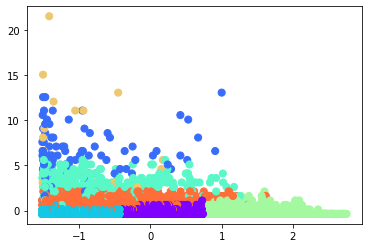

In [10]:
#From this picture k = 6 looks more appropriate
labels = KMeans(8, random_state=0).fit_predict(scaled_features)
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=labels,
            s=50, cmap='rainbow');

#### The Elbrow method for 𝑘 estimation. As shown in the graph  untill point 6 the  calculated sum of squared distances of samples to their closest cluster center  decreases steeply, after 6 it decreases linearly.  This method also shows that  k = 6  looks  more appropriate

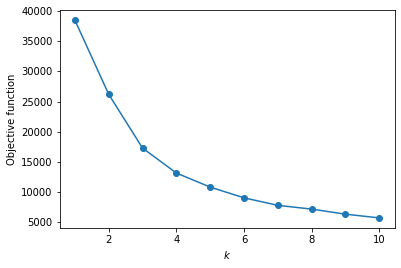

In [11]:
ix = np.zeros(10)
iy = np.zeros(10)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(scaled_features)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Objective function')
plt.plot(ix, iy, 'o-')
plt.show()

#### So by taking into account two approaches in estimation of k value, and triyng to run k-means algorithm with k = 6 and           k = 7 values,after comparing outputs of  Silhouette coefficient (differes in small number) and graphs (shows that in k = 6 => cluster 5 is on  of average silhouette scores,   decided to choose  for  k value = 6, because the difference between Silhouette coefficient for k = 6  and k = 7 were very small, also the final centroids around   (x = -1,y = 6) in scatter graph data are very closed to each other when we have 7 clusters.  It is represented in the end of Homework
#### Also firstly  I tried to implement k-means   initial centers mannually, but after comparing results change to default algorithm to choose centers as ' k-means++'  with n-init =10.

[4 1 1 ... 4 4 4]
[[ 0.10458463 -0.22758972 -0.14874571]
 [ 1.31067744 -0.26349717 -0.19306475]
 [-1.02986178  6.03327016  4.27041252]
 [-0.66388478  1.90793939  1.11122098]
 [-1.03901613 -0.17232692 -0.12821093]
 [-0.80147557  5.84752901 20.48909579]]


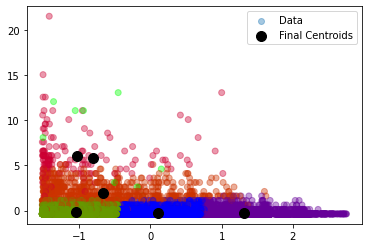

In [15]:
#Final dicision k = 6
k = 6
#initial_centers = np.array([[2,1,0.5],[1,5,0.5], [0.5,4,0.2], [0,2,0.5],[-1,12,1],[-1,3,0.5]])
kmeans = KMeans(n_clusters = k, random_state = 1, init = "k-means++", max_iter=300, n_init = 10).fit(scaled_features)

# to show resulting clusters
print(kmeans.labels_)
# to see cluster centers
print(kmeans.cluster_centers_)

# figure
plt.scatter(scaled_features[:,0], scaled_features[:,1], c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
#plt.scatter(initial_centers[:,0], initial_centers[:,1], c = 'black', s=50, alpha = 0.9, marker = 'x') # initial centers
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'black', s=100) # final centers
plt.legend(['Data', 'Final Centroids'])
plt.show()


In [16]:
kmeans.inertia_

9024.638627833567

In [17]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[ 0.10458463, -0.22758972, -0.14874571],
       [ 1.31067744, -0.26349717, -0.19306475],
       [-1.02986178,  6.03327016,  4.27041252],
       [-0.66388478,  1.90793939,  1.11122098],
       [-1.03901613, -0.17232692, -0.12821093],
       [-0.80147557,  5.84752901, 20.48909579]])

In [18]:
#The number of iterations required to converge
kmeans.n_iter_

12

#### An interpretation of  clusters. Identifing  superstar customers (high monetary, high frequency, low recency) and lousy ones (high recency, low frequency, low monetary):

In [19]:
#displaying  distribution of customers in each cluster 
rfmTable['Cluster'] = kmeans.labels_
rfmTable.sort_values(by="Cluster", ascending=True)

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
8203,1209,1,3.92,0
7436,849,2,458.61,0
7434,1339,1,147.75,0
7433,1339,1,26.25,0
7432,1339,1,64.13,0
...,...,...,...,...
5291,775,28,7189.53,5
6356,421,24,6400.21,5
10230,60,6,6080.52,5


##### Dividing customers into two Identifies: Superstar_customer and Lousy_customer. 
##### Division of customers  is done by filtering original data from rfmTable based on three features as RFM : superstar_customer if = low recency (less than 100 days),  high frequency (> 5 times), high monetary (>5000)  and  else: Lousy_customer = high recency, low frequency, low monetary. The result of filtering is written in a new column "Identify_customer" . As a result we can see that we have only 2 Superstar customers who  are represented in cluster 5 with other 10 Lousy customers.

In [20]:
#Before filtering all data need to be in one data type, so Monetary is converted from float to int64
rfmTable["Monetary"] = rfmTable["Monetary"].apply(np.int64)
rfmTable["Identify_customer"] = np.where(((rfmTable["Recency"] < 100) & (rfmTable["Frequency"] > 5) & (rfmTable["Monetary"] > 5000)), 'Superstar_customer', 'Lousy_customer')
rfmTable.sort_values(by="Cluster", ascending=False)

,Recency,Frequency,Monetary,Cluster,Identify_customer
Customer ID,,,,,
8473,738,8,5580,5,Lousy_customer
4912,1024,5,21392,5,Lousy_customer
4148,1214,11,7455,5,Lousy_customer
5291,775,28,7189,5,Lousy_customer
7415,116,26,5470,5,Lousy_customer
...,...,...,...,...,...
9128,1080,1,10,0,Lousy_customer
9126,1080,1,28,0,Lousy_customer
9125,1081,1,195,0,Lousy_customer


In [21]:
#Table shows mean values of feautures  and the number of customers in each cluster.
print('Cluster summary(mean values):')
summary = rfmTable.groupby(['Cluster']).mean()
summary['Count'] = rfmTable['Cluster'].value_counts()
summary_mean = summary.sort_values(by='Count', ascending=False)
print(summary)

Cluster summary(mean values):
             Recency  Frequency     Monetary  Count
Cluster                                            
0        1181.362801   1.289552    94.681286   4355
1        2056.388301   1.216931    76.364785   3402
2         354.406667  13.873333  1896.453333    150
3         620.294811   5.577830   607.574292    848
4         349.439931   1.398080   103.033973   4062
5         520.333333  13.500000  8509.333333     12


In [22]:
#Table shows max values of feautures in each cluster along with the number of customers and their ifentifies (superstar/lousy)
print('Cluster summary(max_values):')
summary_max = rfmTable.groupby(['Cluster']).max()
summary_max['Count'] = rfmTable['Cluster'].value_counts()
summary_mean = summary.sort_values(by='Count', ascending=False)
print(summary_max)


Cluster summary(max_values):
         Recency  Frequency  Monetary   Identify_customer  Count
Cluster                                                         
0           1653          4      1107      Lousy_customer   4355
1           3103          5      1038      Lousy_customer   3402
2           1842         45      5020      Lousy_customer    150
3           2281         12      2705      Lousy_customer    848
4            790          4      1151      Lousy_customer   4062
5           1214         28     21392  Superstar_customer     12


In [23]:
#Table shows min values of feautures in each cluster along with the number of customers and their ifentifies (superstar/lousy)
print('Cluster summary(min values):')
summary_min = rfmTable.groupby(['Cluster']).min()
summary_min['Count'] = rfmTable['Cluster'].value_counts()
summary_mean = summary.sort_values(by='Count', ascending=False)
print(summary_min)

Cluster summary(min values):
         Recency  Frequency  Monetary Identify_customer  Count
Cluster                                                       
0            755          1         1    Lousy_customer   4355
1           1611          1         1    Lousy_customer   3402
2              2          5       612    Lousy_customer    150
3              1          1        68    Lousy_customer    848
4              0          1         1    Lousy_customer   4062
5              9          2      5470    Lousy_customer     12


In [24]:
#this Table shows  the perrezentation of the number of customers with their identifies (superstar/lousy) in each cluster:
print('Cluster summary(Identifying customers based on clusters):')
Identify_Customers = rfmTable.groupby(["Cluster", 'Identify_customer' ])["Identify_customer"].count().rename("Number_Customers").reset_index()
Identify_Customers

Cluster summary(Identifying customers based on clusters):


,Cluster,Identify_customer,Number_Customers
0,0,Lousy_customer,4355
1,1,Lousy_customer,3402
2,2,Lousy_customer,150
3,3,Lousy_customer,848
4,4,Lousy_customer,4062
5,5,Lousy_customer,10
6,5,Superstar_customer,2


#### When number of clusters are equal to  from 1 to 5 incl.we can see in a below graph that they are a bad pick for our example due to the presence of clusters with  below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots.
#### Out of all examples k = 6 looks more acceptible, however we can see that clusters have no similar thickness, for example clusters(2, 4, 5) are presented in a very small numbers of features.

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.7223387938868856
For n_clusters = 3 The average silhouette_score is : 0.4699994399565774
For n_clusters = 4 The average silhouette_score is : 0.4828698454274579
For n_clusters = 5 The average silhouette_score is : 0.48946767181532236
For n_clusters = 6 The average silhouette_score is : 0.4186440037650195
For n_clusters = 7 The average silhouette_score is : 0.42169767115716356


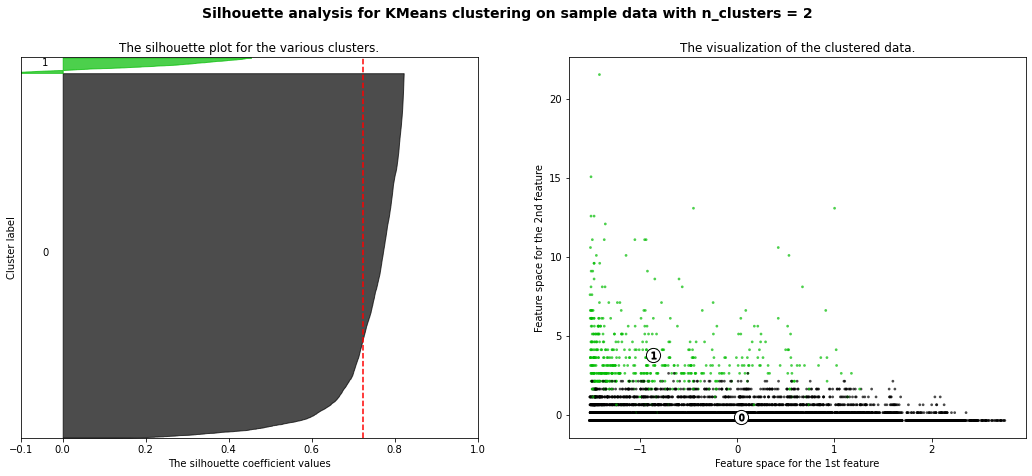

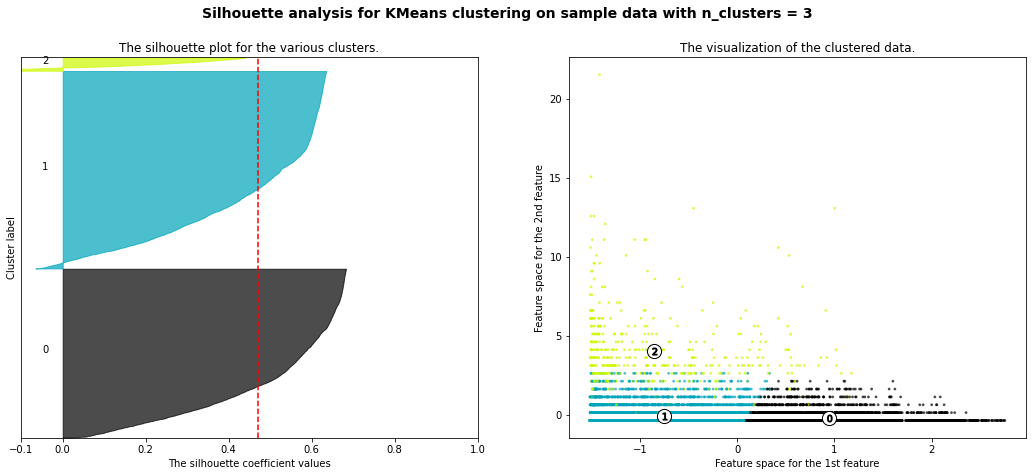

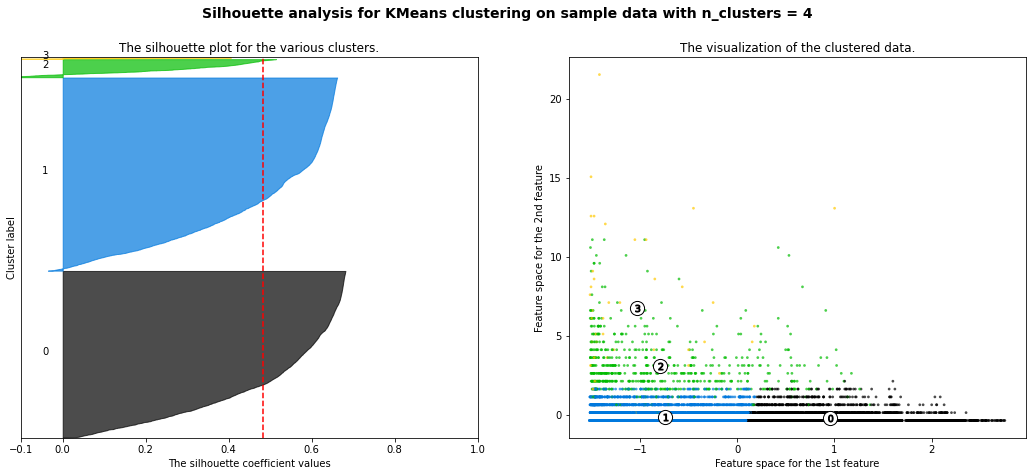

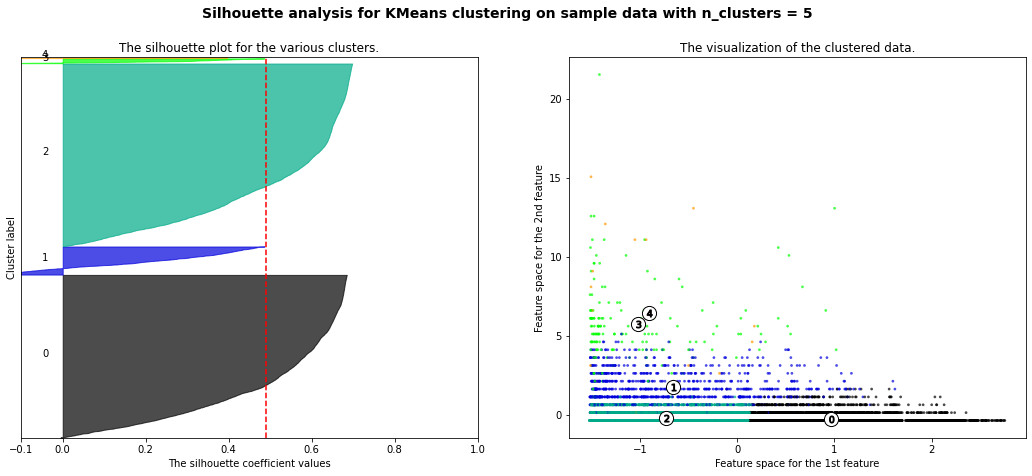

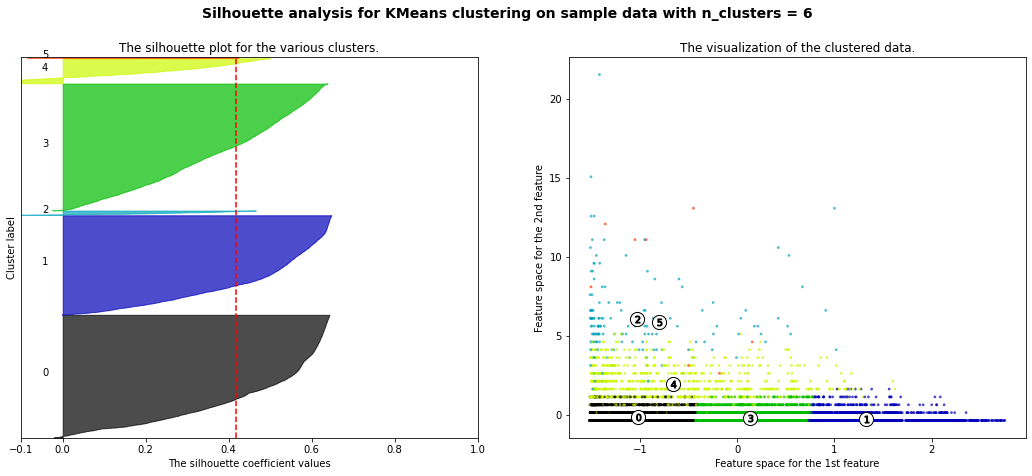

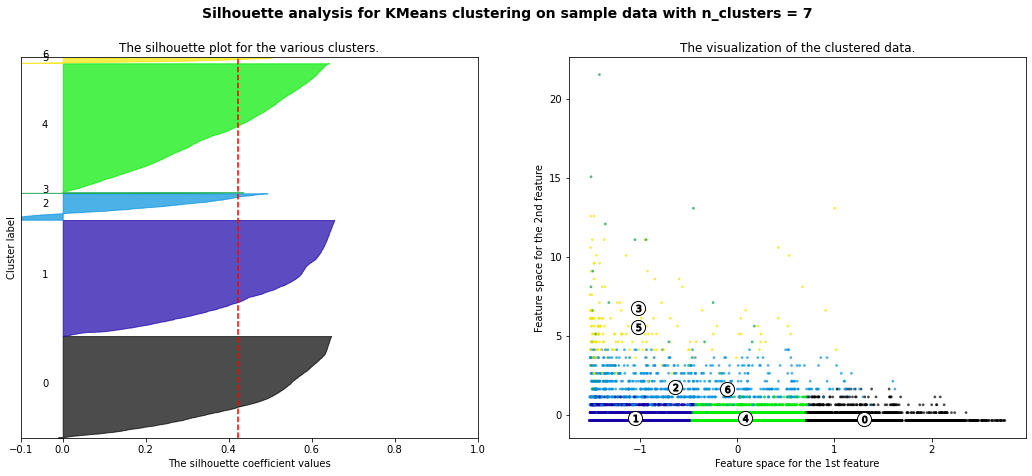

In [420]:
#This piece of code from website scikit-learn.org

print(__doc__)

range_n_clusters = [2, 3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaled_features) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(scaled_features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(scaled_features[:, 0], scaled_features[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()